# Setup


In [ ]:
%conda install pytorch torchvision torchaudio cudatoolkit = 11.3 - c pytorch
%conda install numpy pandas matplotlib
%pip install opencv-python keyboard Pillow pyautogui wandb


In [58]:
import os
import time
import shutil
import copy
import uuid
import numpy as np
import cv2
import keyboard as kb
from PIL import ImageGrab, ImageFilter
import pyautogui
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import wandb

import torch
import torchvision
import torch.nn as nn
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision import datasets, transforms, utils, models
import torch.optim as optim
from torch.optim import lr_scheduler


In [ ]:
# Gets coordinates for bbox
kb.wait('enter')

currentMouseX, currentMouseY = pyautogui.position()
print(f'({currentMouseX}, {currentMouseY})')


In [59]:
BBOX = (2, 113, 1275, 1027)
DATA_DIR = 'data'
EPOCHS = 25
LEARNING_RATE = 0.001
MOMENTUM = 0.9
STEP_SIZE = 7
GAMMA = 0.1


# Data Collection


In [62]:
# Resets data folder
dirpath = Path('data')
if dirpath.exists():
    shutil.rmtree(dirpath)

os.makedirs(os.path.join('data', 'w'))
os.makedirs(os.path.join('data', 'a'))
os.makedirs(os.path.join('data', 's'))
os.makedirs(os.path.join('data', 'd'))


In [60]:
def shoot_screen():
    screenshot = ImageGrab.grab(bbox=BBOX)
    return screenshot


In [66]:
dir = ''

while True:

    if kb.is_pressed('w'):
        dir = 'w'
    elif kb.is_pressed('a'):
        dir = 'a'
    elif kb.is_pressed('s'):
        dir = 's'
    elif kb.is_pressed('d'):
        dir = 'd'
    else:
        dir = ''

    if dir != '':
        screenshot = shoot_screen()
        filename = str(uuid.uuid4()) + '.jpg'
        screenshot.save(f'data/{dir}/{filename}')

    if kb.is_pressed('esc'):
        print('Exiting data collection!')
        break


Exiting data collection!


# Training


## Load Data


In [67]:
wandb.login()
wandb.init(project="paper-io-ai", config={
    "epochs": EPOCHS,
    "learning_rate": LEARNING_RATE,
    "momentum": MOMENTUM,
    "step_size": STEP_SIZE,
    "gamma": GAMMA
})


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: eddiezhuang. Use `wandb login --relogin` to force relogin


In [68]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485], [0.229])
])


In [69]:
data = datasets.ImageFolder(DATA_DIR, data_transform)

train_size = int(0.8 * len(data))
val_size = len(data) - train_size

train_data, val_data = torch.utils.data.random_split(
    data, [train_size, val_size])
image_datasets = {
    'train': train_data,
    'val': val_data
}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = data.classes

device = torch.device("cuda:0")
torch.cuda.get_device_name(device)


'NVIDIA GeForce GTX 1650'

## Visualize Images


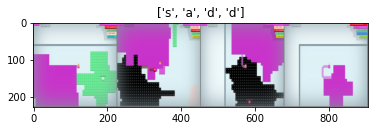

In [70]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485])
    std = np.array([0.229])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


## Train the Model


In [71]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=EPOCHS):
    wandb.watch(model, log_freq=100)

    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)  # load data to GPU
                labels = labels.to(device)

                optimizer.zero_grad()  # clear gradients for this training step

                with torch.set_grad_enabled(phase == 'train'):
                    # Calculate loss
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            wandb.log({"loss": epoch_loss, "acc": epoch_acc})

            # save the model if it is the best so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(
        f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    wandb.log({"best_acc": best_acc})

    model.load_state_dict(best_model_wts)
    return model


In [72]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_df = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(),
                         lr=LEARNING_RATE, momentum=MOMENTUM)

exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_ft, step_size=STEP_SIZE, gamma=GAMMA)


In [73]:
model_ft = train_model(model_ft, criterion, optimizer_ft,
                       exp_lr_scheduler, EPOCHS)


Epoch 1/25
----------
train Loss: 1.2702 Acc: 0.4724
val Loss: 0.8231 Acc: 0.7332

Epoch 2/25
----------
train Loss: 0.8560 Acc: 0.7020
val Loss: 0.4796 Acc: 0.8319

Epoch 3/25
----------
train Loss: 0.5949 Acc: 0.7882
val Loss: 0.3705 Acc: 0.8761

Epoch 4/25
----------
train Loss: 0.4585 Acc: 0.8481
val Loss: 0.2889 Acc: 0.8866

Epoch 5/25
----------
train Loss: 0.3473 Acc: 0.8797
val Loss: 0.3390 Acc: 0.8866

Epoch 6/25
----------
train Loss: 0.3369 Acc: 0.8923
val Loss: 0.2786 Acc: 0.9055

Epoch 7/25
----------
train Loss: 0.2727 Acc: 0.9101
val Loss: 0.2338 Acc: 0.9139

Epoch 8/25
----------
train Loss: 0.1562 Acc: 0.9496
val Loss: 0.1993 Acc: 0.9349

Epoch 9/25
----------
train Loss: 0.1194 Acc: 0.9643
val Loss: 0.2162 Acc: 0.9244

Epoch 10/25
----------
train Loss: 0.0978 Acc: 0.9706
val Loss: 0.2067 Acc: 0.9202

Epoch 11/25
----------
train Loss: 0.1060 Acc: 0.9706
val Loss: 0.2126 Acc: 0.9160

Epoch 12/25
----------
train Loss: 0.1027 Acc: 0.9737
val Loss: 0.2027 Acc: 0.9160

E

## Visualize Model Predictions


In [74]:
def visualize_model(model, num_images=6):
    """Shows predictions for a few images"""
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():  # Reduces memory consumption for inference
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Returns the max output

            for j in range(inputs.size()[0]):
                images_so_far += 1

                # // divides and only keeps the integer part
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


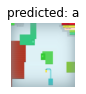

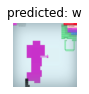

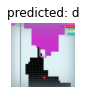

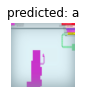

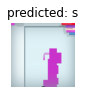

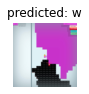

In [75]:
visualize_model(model_ft)


## Save Model


In [76]:
torch.save(model_ft, os.path.join(wandb.run.dir, 'model.pt'))


In [77]:
wandb.finish()


acc,▁▅▄▆▆▆▇▇▇▇▇▇▇█▇██▇█▇▇█▇██▇█▇▇█▇██▇█▇▇█▇▇
best_acc,▁
loss,█▅▆▃▃▃▂▃▃▂▂▂▂▁▂▁▁▂▁▂▂▁▂▁▁▂▁▂▂▁▂▁▁▂▁▂▂▁▂▂
acc,0.90756
best_acc,0.93487
loss,0.21401


# Playing


## Load the Model


In [78]:
model_file = wandb.restore(
    'model.pt', run_path="eddiezhuang/paper-io-ai/1o0dyh11")

model = torch.load(model_file.name)
model.to(device)
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Play in Real Time!


In [117]:
def get_pred():
    screenshot = shoot_screen()
    screenshot = data_transform(screenshot).to(device)
    screenshot = screenshot.unsqueeze(0)
    output = model(screenshot)
    _, preds = torch.max(output, 1)
    key = class_names[preds[0]]
    return key

In [119]:
kb.wait('enter')
print('Starting AI playing...')

with torch.no_grad():
    while True:
        key = get_pred()
        print(key)

        kb.send(key)

        if kb.is_pressed('esc'):
            print('Exiting AI playing!')
            break


Starting AI playing...
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s
s